In [44]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)

-1.0 1.001 0.04470273766021792 0.211
PWV -> nscale: -1.00
zenith -> airmass: 1.00


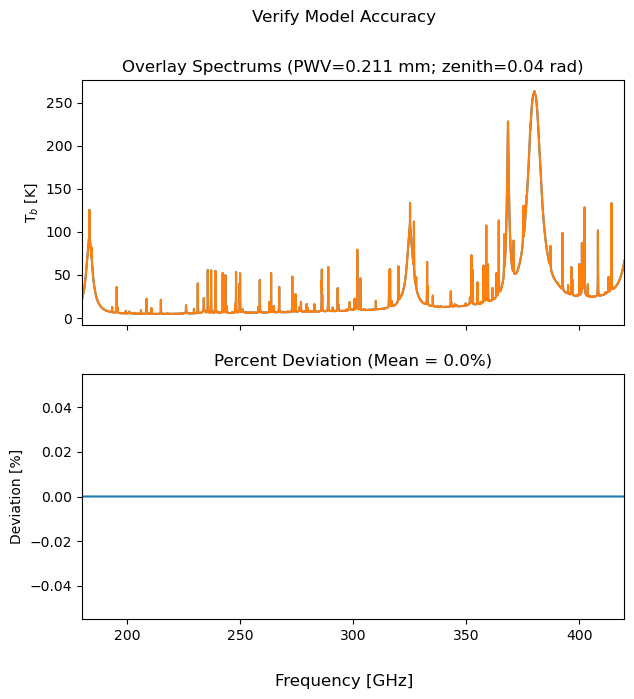

In [94]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

idx = 0
print(nscale_map[idx], airmass_map[idx], zenith_map[idx], pwv_map[idx])

Tb_data = my_ozone.data['Tb_scalar_field'][idx,idx]
model_spectrum = my_ozone(pwv_map[idx], zenith_map[idx])[0][0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Accuracy")

ax1.plot(freq_channels, Tb_data)
ax1.plot(freq_channels, model_spectrum)
ax1.set_title(f"Overlay Spectrums (PWV={pwv_map[idx]} mm; zenith={zenith_map[idx]:.2f} rad)")
ax1.set_ylabel(r'T$_b$ [K]')

comparison = ((model_spectrum - Tb_data) / Tb_data) * 100
ax2.plot(freq_channels, comparison)
ax2.set_title(f"Percent Deviation (Mean = {np.mean(comparison)}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));

In [103]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

verify_map = np.zeros((my_ozone.data['Nscale']['points'], my_ozone.data['airmass']['points']))

for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        Tb_data = my_ozone.data['Tb_scalar_field'][idx,jdx]
        model_spectrum = my_ozone(pwv_map[idx], zenith_map[jdx])[0][0] 
        comparison = ((model_spectrum - Tb_data) / Tb_data) * 100
        verify_map[idx,jdx] = np.mean(comparison)

PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.30
PWV -> nscale: -1.00
zenith -> airmass: 1.60
PWV -> nscale: -1.00
zenith -> airmass: 1.90
PWV -> nscale: -1.00
zenith -> airmass: 2.20
PWV -> nscale: -1.00
zenith -> airmass: 2.50
PWV -> nscale: -1.00
zenith -> airmass: 2.80
PWV -> nscale: -1.00
zenith -> airmass: 3.10
PWV -> nscale: -1.00
zenith -> airmass: 3.40
PWV -> nscale: -1.00
zenith -> airmass: 3.70
PWV -> nscale: -1.00
zenith -> airmass: 4.00
PWV -> nscale: -0.90
zenith -> airmass: 1.00
PWV -> nscale: -0.90
zenith -> airmass: 1.30
PWV -> nscale: -0.90
zenith -> airmass: 1.60
PWV -> nscale: -0.90
zenith -> airmass: 1.90
PWV -> nscale: -0.90
zenith -> airmass: 2.20
PWV -> nscale: -0.90
zenith -> airmass: 2.50
PWV -> nscale: -0.90
zenith -> airmass: 2.80
PWV -> nscale: -0.90
zenith -> airmass: 3.10
PWV -> nscale: -0.90
zenith -> airmass: 3.40
PWV -> nscale: -0.90
zenith -> airmass: 3.70
PWV -> nscale: -0.90
zenith -> airmass: 4.00
PWV -> nsc

Text(0.02, 0.5, 'Deviation [%]')

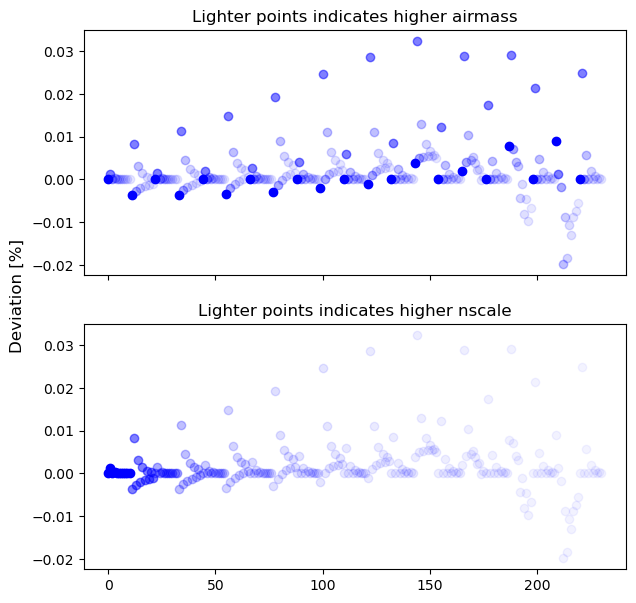

In [126]:
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))

count = 0
for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        color = mcolors.to_rgba('blue', alpha=1/(jdx+1))
        ax1.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax1.set_title("Lighter points indicates higher airmass")

count = 0
for idx, nscale in enumerate(nscale_map):
    color = mcolors.to_rgba('blue', alpha=1/(idx+1))
    for jdx, airmass in enumerate(airmass_map):
        ax2.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax2.set_title("Lighter points indicates higher nscale")

fig.supylabel("Deviation [%]")

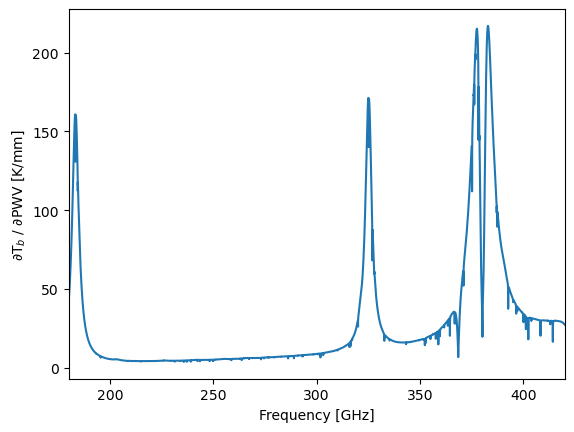

In [135]:
plt.ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
plt.xlabel('Frequency [GHz]')
plt.xlim(min(freq_channels), max(freq_channels))
plt.plot(freq_channels, my_ozone.data['Nscale']['jacobian'][0,0])